PGSQL|didadata|0|rows=10079, columns=4|2023-11-23 17:36:18


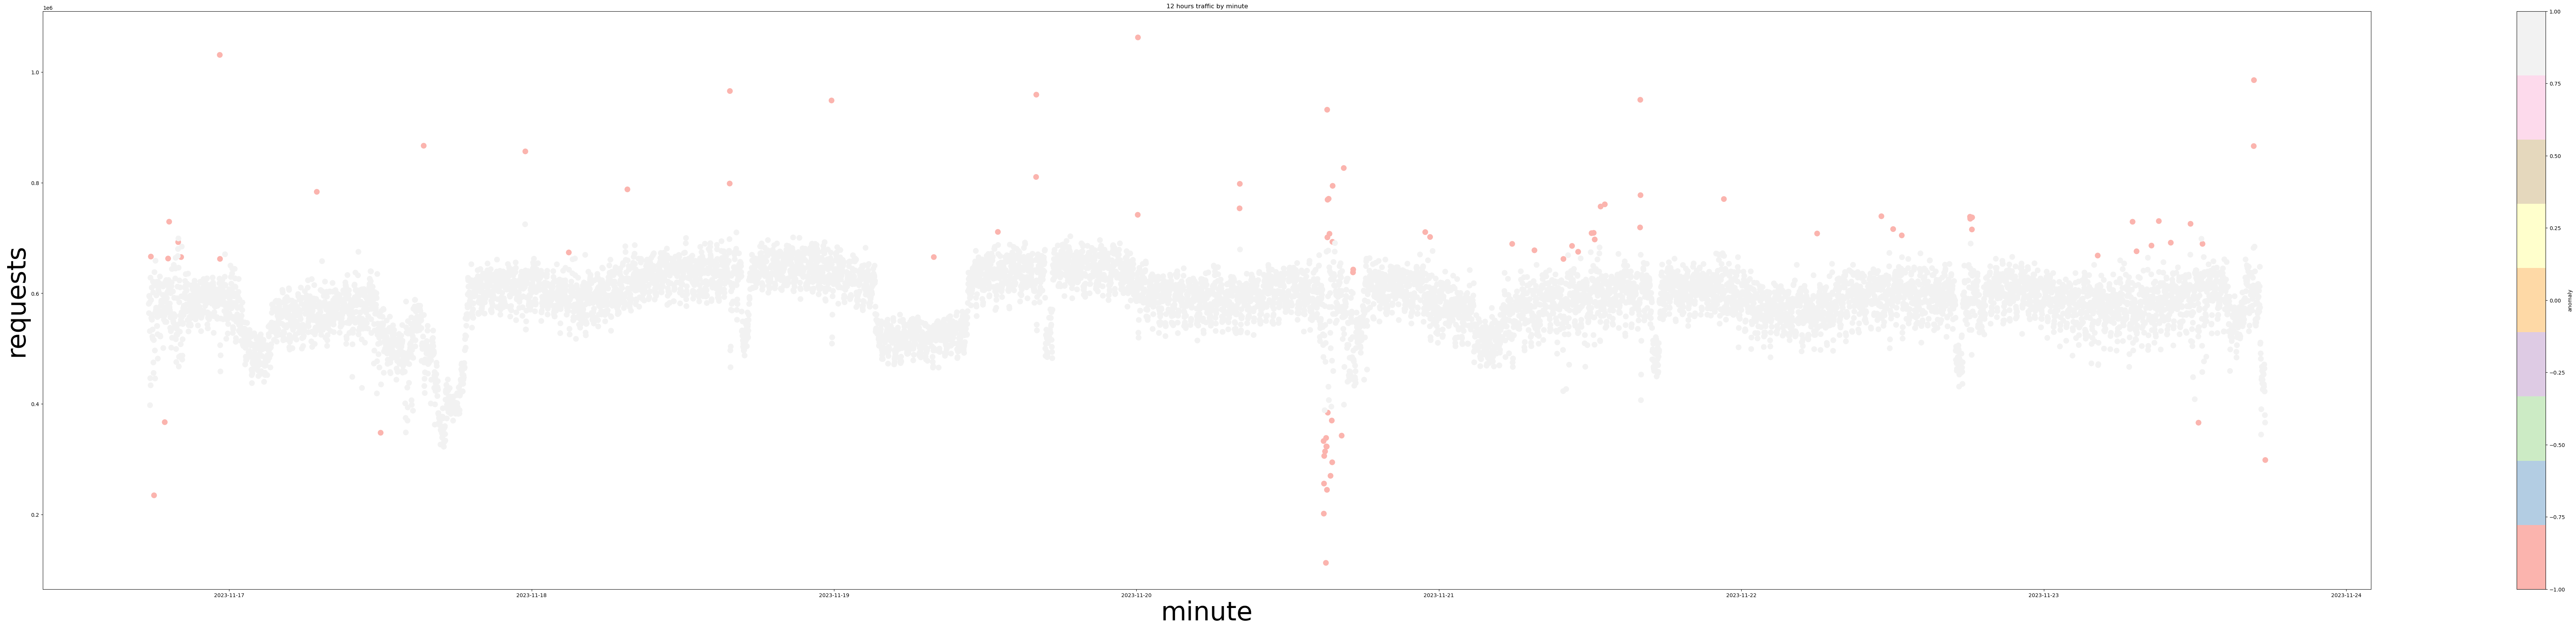

In [61]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np
import oldchicken as oc # 就是封装了一下从hologres取数的方法
sql = '''select date_trunc('minute',logtime) tm,clientid,sum(amount) count
,sum(case
    when entrancetype = 'DidaBizRate' and resulttype not in (100, 110, 120) then case
                when biztype = 'HotelRateSearch_RealTime_SingleHotel' THEN amount * 0.37
                when biztype = 'HotelRateSearch_RealTime_MultiHotel' THEN amount * 0.14
                when biztype = 'HotelRateSearch_Cache_MultiHotel' THEN amount * 0.35
                else 0 end
    when entrancetype = 'SupplierServiceAsync' then amount * 0.074
    else 0 end) as uamount
from public.didamonitor_grafana_dws
where logtime between now()- interval '7 days' and now() and entrancetype in ('DidaBizRate','SupplierServiceAsync')
and clientid = 'Agoda'
group by 1,2'''
traffic_df = oc.DB().sql_to_df(sql,0,'PGSQL')
df = traffic_df.query("clientid == 'Agoda'")
tgt_column = 'uamount'
# 构建模型 ,n_estimators=100 ,构建100颗树
model = IsolationForest(n_estimators=10, max_samples=100, contamination=float(0.01), max_features=1.0)
# 训练模型
model.fit(df[[tgt_column]])
# 预测 decision_function 可以得出 异常评分
df['scores'] = model.decision_function(df[[tgt_column]])
#  predict() 函数 可以得到模型是否异常的判断，-1为异常，1为正常
df['anomaly'] = model.predict(df[[tgt_column]])
result = df.copy()
df.plot.scatter('tm', 'count', c='anomaly', s=100, colormap='Pastel1',figsize=(100,20))
plt.title('12 hours traffic by minute')
plt.xlabel('minute', fontsize=50)
plt.ylabel('requests', fontsize=50)
plt.show()

In [43]:
import warnings 
warnings.filterwarnings("ignore")

In [62]:
n = 1000
data =  df.sort_values(by='scores',ascending=True)
data = data.head(n)
rate = data[data['anomaly']==1].shape[0]/n
print('Top{}的准确率为:{}'.format(n,rate))

Top1000的准确率为:0.913


# 调整参数n_estimators

Top1000的准确率为:0.913
Top1000的准确率为:0.902
Top1000的准确率为:0.907
Top1000的准确率为:0.902
Top1000的准确率为:0.901
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.901
Top1000的准确率为:0.9
Top1000的准确率为:0.904
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.901
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.901
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.901
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.901
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899


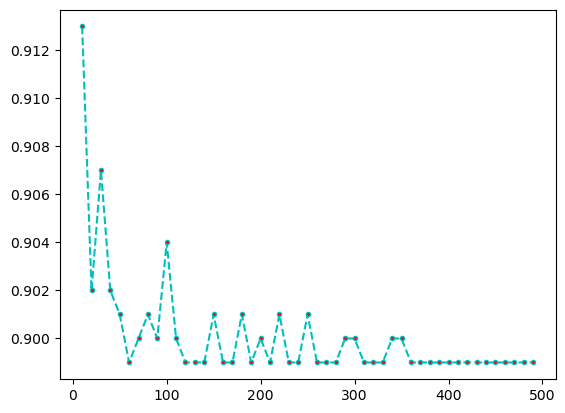

In [14]:
n_est = list(range(10,500,10))
rates = []
for i in n_est:
    # 模型训练
    iforest = IsolationForest(n_estimators=i, 
                              max_samples=256,  
                              contamination=0.01, 
                              max_features=1,  
                              random_state=1
                              )
    #fit_predict 函数 训练和预测一起 可以得到模型是否异常的判断，-1为异常，1为正常
    df['anomaly'] = iforest.fit_predict(df[[tgt_column]]) 
    # 预测 decision_function 可以得出 异常评分
    df['scores'] = iforest.decision_function(df[[tgt_column]])  
    # TopN准确率评估
    n = 1000
    data =  df.sort_values(by='scores',ascending=True)
    data = data.head(n)
    rate = data[data['anomaly']==1].shape[0]/n
    print('Top{}的准确率为:{}'.format(n,rate))
    rates.append(rate)
plt.plot(n_est,rates, linestyle='--', marker='.',color='c',markerfacecolor='red')
plt.show()

# 调整参数max_samples

Top1000的准确率为:0.9
Top1000的准确率为:0.903
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.901
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.901
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.901
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.901
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.901
Top1000的准确率为:0.901
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.901
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.901
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.901
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.901
Top1000的准确

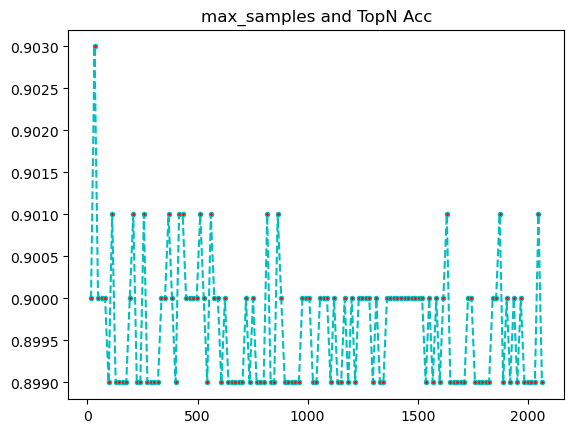

In [27]:
samples = list(range(16,2066,16))
rates = []
for i in samples:
    # 模型训练
    iforest = IsolationForest(n_estimators=100, 
                              max_samples=i,  
                              contamination=0.01, 
                              max_features=1,  
                              random_state=1
                              )
    #fit_predict 函数 训练和预测一起 可以得到模型是否异常的判断，-1为异常，1为正常
    df['anomaly'] = iforest.fit_predict(df[[tgt_column]]) 
    # 预测 decision_function 可以得出 异常评分
    df['scores'] = iforest.decision_function(df[[tgt_column]])  
    # TopN准确率评估
    n = 1000
    data =  df.sort_values(by='scores',ascending=True)
    data = data.head(n)
    rate = data[data['anomaly']==1].shape[0]/n
    print('Top{}的准确率为:{}'.format(n,rate))
    rates.append(rate)
plt.plot(samples,rates, linestyle='--', marker='.',color='c',markerfacecolor='red')
plt.title('max_samples and TopN Acc')
plt.show()

Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.901
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899


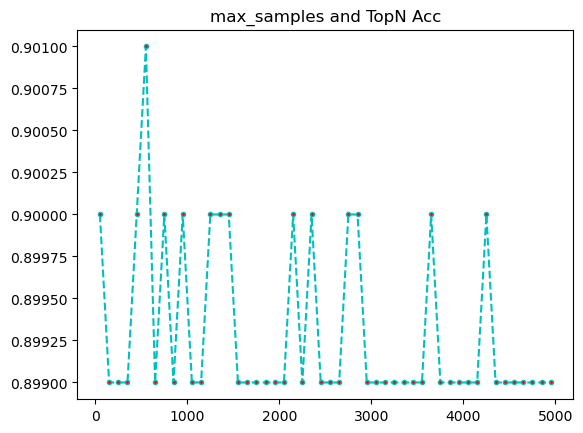

In [28]:
samples = list(range(50,5000,100))
rates = []
for i in samples:
    # 模型训练
    iforest = IsolationForest(n_estimators=100, 
                              max_samples=i,  
                              contamination=0.01, 
                              max_features=1,  
                              random_state=1
                              )
    #fit_predict 函数 训练和预测一起 可以得到模型是否异常的判断，-1为异常，1为正常
    df['anomaly'] = iforest.fit_predict(df[[tgt_column]]) 
    # 预测 decision_function 可以得出 异常评分
    df['scores'] = iforest.decision_function(df[[tgt_column]])  
    # TopN准确率评估
    n = 1000
    data =  df.sort_values(by='scores',ascending=True)
    data = data.head(n)
    rate = data[data['anomaly']==1].shape[0]/n
    print('Top{}的准确率为:{}'.format(n,rate))
    rates.append(rate)
plt.plot(samples,rates, linestyle='--', marker='.',color='c',markerfacecolor='red')
plt.title('max_samples and TopN Acc')
plt.show()

Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.903
Top1000的准确率为:0.903
Top1000的准确率为:0.903
Top1000的准确率为:0.902
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.903
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.903
Top1000的准确率为:0.9
Top1000的准确率为:0.903
Top1000的准确率为:0.901
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.901
Top1000的准确率为:0.901
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.902
Top1000的准确率为:0.902
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.901
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.901
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为

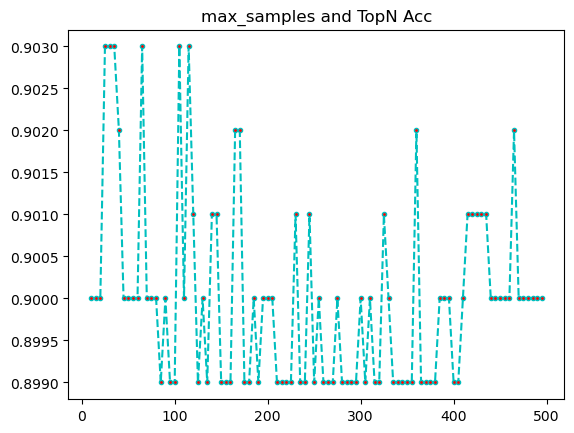

In [29]:
samples = list(range(10,500,5))
rates = []
for i in samples:
    # 模型训练
    iforest = IsolationForest(n_estimators=100, 
                              max_samples=i,  
                              contamination=0.01, 
                              max_features=1,  
                              random_state=1
                              )
    #fit_predict 函数 训练和预测一起 可以得到模型是否异常的判断，-1为异常，1为正常
    df['anomaly'] = iforest.fit_predict(df[[tgt_column]]) 
    # 预测 decision_function 可以得出 异常评分
    df['scores'] = iforest.decision_function(df[[tgt_column]])  
    # TopN准确率评估
    n = 1000
    data =  df.sort_values(by='scores',ascending=True)
    data = data.head(n)
    rate = data[data['anomaly']==1].shape[0]/n
    print('Top{}的准确率为:{}'.format(n,rate))
    rates.append(rate)
plt.plot(samples,rates, linestyle='--', marker='.',color='c',markerfacecolor='red')
plt.title('max_samples and TopN Acc')
plt.show()

Top1000的准确率为:0.953
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.903
Top1000的准确率为:0.903
Top1000的准确率为:0.903
Top1000的准确率为:0.902
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.903
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.9
Top1000的准确率为:0.899
Top1000的准确率为:0.9
Top1000的准确率为:0.899


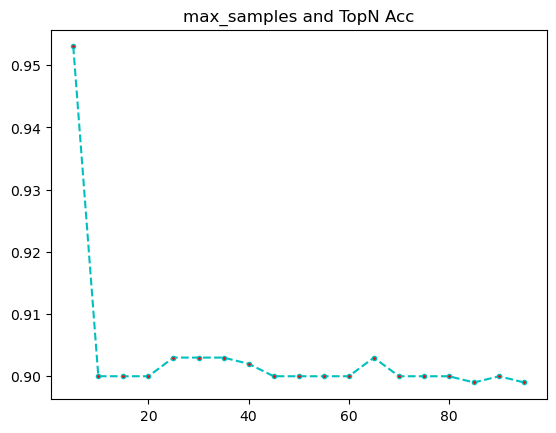

In [32]:
samples = list(range(5,100,5))
rates = []
for i in samples:
    # 模型训练
    iforest = IsolationForest(n_estimators=100, 
                              max_samples=i,  
                              contamination=0.01, 
                              max_features=1,  
                              random_state=1
                              )
    #fit_predict 函数 训练和预测一起 可以得到模型是否异常的判断，-1为异常，1为正常
    df['anomaly'] = iforest.fit_predict(df[[tgt_column]]) 
    # 预测 decision_function 可以得出 异常评分
    df['scores'] = iforest.decision_function(df[[tgt_column]])  
    # TopN准确率评估
    n = 1000
    data =  df.sort_values(by='scores',ascending=True)
    data = data.head(n)
    rate = data[data['anomaly']==1].shape[0]/n
    print('Top{}的准确率为:{}'.format(n,rate))
    rates.append(rate)
plt.plot(samples,rates, linestyle='--', marker='.',color='c',markerfacecolor='red')
plt.title('max_samples and TopN Acc')
plt.show()